In [1]:
# ---------------------------------------------------------
# GOOGLE COLAB SETUP
# ---------------------------------------------------------
import sys
import os
import subprocess

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Detected Google Colab environment.")
    
    # ---------------------------------------------------------
    # 1. Installation Check
    # ---------------------------------------------------------
    needs_install = False
    
    # Check if pot is installed
    try:
        import ot
    except ImportError:
        print("POT (Python Optimal Transport) not found. Installation required.")
        needs_install = True
        
    # Check if geomloss is installed
    try:
        import geomloss
    except ImportError:
        print("GeomLoss not found. Installation required.")
        needs_install = True

    # Check if tqdm is installed
    try:
        import tqdm
    except ImportError:
        print("tqdm not found. Installation required.")
        needs_install = True

    if needs_install:
        print("Installing required packages (this may take a minute)...")
        !pip install -q -U pot geomloss tqdm
        
        print("\n" + "="*80)
        print("INSTALLATION COMPLETE.")
        print("="*80 + "\n")
    else:
        print("Environment appears correct. Skipping installation.")

    # ---------------------------------------------------------
    # 2. Download Dataset
    # ---------------------------------------------------------
    # MNIST is downloaded automatically by torchvision in the next cells.
    print("MNIST dataset will be downloaded by torchvision.")
        
else:
    print("Not running in Google Colab. Assuming local environment.")

Not running in Google Colab. Assuming local environment.


In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
from torchvision import datasets

print(f"NumPy version: {np.__version__}")
print("Libraries imported successfully.")

/oscar/home/mleblan6/work/ot/BrownAI26-OT/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


NumPy version: 2.0.2
Libraries imported successfully.


100%|██████████| 9.91M/9.91M [00:00<00:00, 72.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.52MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 27.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.34MB/s]


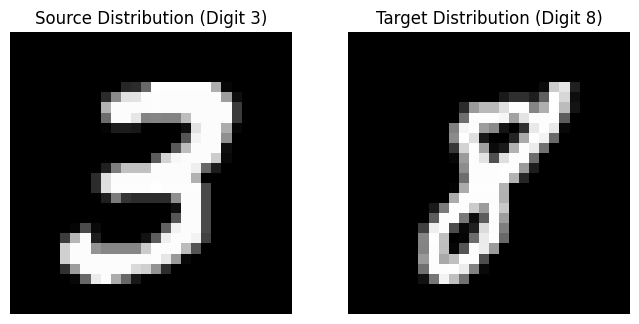

In [5]:
# Data Prep: Load MNIST via torchvision and select two digits
# Download MNIST (PIL images) and convert to numpy arrays
mnist_train = datasets.MNIST(root='.', train=True, download=True)
x_train = np.array([np.array(img, dtype=np.float64) for img, _ in mnist_train])
y_train = np.array([label for _, label in mnist_train])

# Select a '3' and an '8'
idx3 = np.where(y_train == 3)[0][0]
idx8 = np.where(y_train == 8)[0][0]

img1 = x_train[idx3].astype(np.float64)
img2 = x_train[idx8].astype(np.float64)

# Normalize so pixel intensities sum to 1 (probability distributions)
img1 /= img1.sum()
img2 /= img2.sum()

# Flatten for processing
n_pixels = 28 * 28
a = img1.flatten()
b = img2.flatten()

# Visualize the chosen images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title("Source Distribution (Digit 3)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title("Target Distribution (Digit 8)")
plt.axis('off')
plt.show()

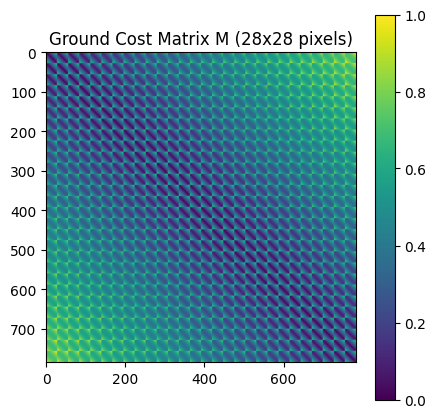

In [6]:
# Geometry: Create Ground Cost Matrix based on pixel coordinates

# Create a grid of coordinates (x, y)
x, y = np.mgrid[0:28, 0:28]
coords = np.vstack((x.flatten(), y.flatten())).T

# Compute Euclidean distance matrix between all pairs of pixels
# M[i, j] is the distance between pixel i and pixel j
M = ot.dist(coords, coords, metric='euclidean')

# Normalize M for numerical stability (optional but recommended)
M /= M.max()

plt.figure(figsize=(5, 5))
plt.imshow(M, cmap='viridis')
plt.title("Ground Cost Matrix M (28x28 pixels)")
plt.colorbar()
plt.show()

In [7]:
# Metric Comparison: Euclidean vs. Earth Mover's Distance

# 1. Euclidean Distance (L2 Norm)
# Does not consider geometry; treats pixels as independent features.
euclidean_dist = np.linalg.norm(a - b)

# 2. Earth Mover's Distance (Wasserstein-1)
# Computes the minimum cost to transport mass from 'a' to 'b' given cost matrix M.
# ot.emd2 returns the cost value.
emd_dist = ot.emd2(a, b, M)

print(f"Euclidean Distance: {euclidean_dist:.4f}")
print(f"Earth Mover's Distance: {emd_dist:.4f}")

# Comment:
# Notice that EMD gives a meaningful distance based on the geometry of the image.
# Even if two digits are non-overlapping, EMD will be proportional to how far the pixels need to move.
# Euclidean distance would just be constant for non-overlapping shapes (sqrt(sum(a^2) + sum(b^2))).

Euclidean Distance: 0.0752
Earth Mover's Distance: 0.0436


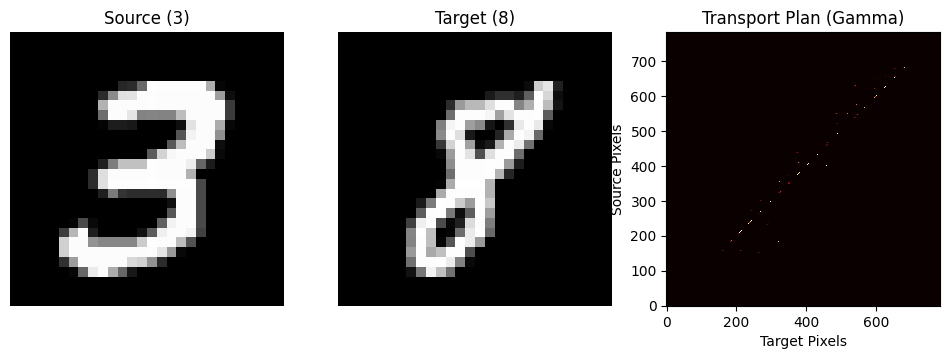

The Transport Plan shows which source pixels map to which target pixels.


In [8]:
# Visualization: Transport Plan

# Compute the optimal transport plan (matrix gamma)
# gamma[i, j] is the amount of mass moved from pixel i in source to pixel j in target.
gamma = ot.emd(a, b, M)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Source (3)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Target (8)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gamma, cmap='hot', interpolation='nearest', origin='lower')
plt.title("Transport Plan (Gamma)")
plt.xlabel("Target Pixels")
plt.ylabel("Source Pixels")
plt.show()

print("The Transport Plan shows which source pixels map to which target pixels.")


<Figure size 1200x500 with 0 Axes>

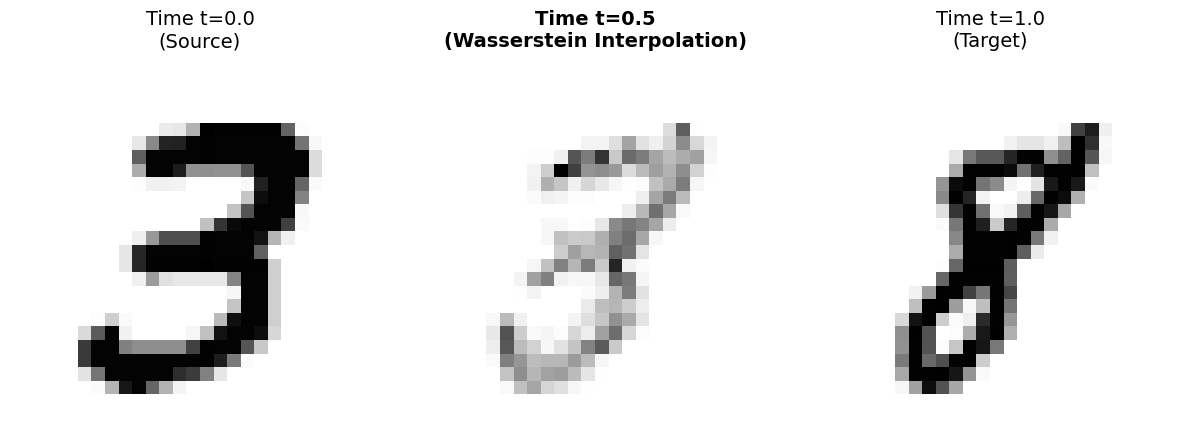

Interpretation:
Look at the middle image. It is NOT a double exposure.
The top curve of the '3' has physically slid down to become the top loop of the '8'.
This 'sliding' is exactly what the Transport Flow describes.


In [9]:
# @title **Experiment 8: The "Geodesic" (Morphing 3 into 8)**
# @markdown This shows *why* the flow matters. We move the ink 50% along the transport lines.

# 1. Setup Coordinates
# We need the (x,y) coordinates of every pixel to calculate the shift
x, y = np.mgrid[0:28, 0:28]
coords = np.vstack((x.flatten(), y.flatten())).T

# 2. Define the Interpolation Function
def make_interpolated_image(T, coords=None, side=None, t=0.5, threshold_frac=0.0):
    """
    Moves mass from source to target using bilinear splatting to preserve detail.
    - T: square transport matrix (n x n)
    - coords: optional (n,2) pixel coordinates; if None, generated from `side`
    - side: image side length (in pixels). If None, inferred from T.shape[0]
    - t: interpolation fraction (0->source, 1->target)
    - threshold_frac: fraction of T.max() below which flows are ignored (0 keeps all)
    """
    n_src, n_tgt = T.shape
    if n_src != n_tgt:
        raise ValueError(f\
)
    n = n_src
    if side is None:
        side = int(np.round(np.sqrt(n)))
    if coords is None:
        xg, yg = np.mgrid[0:side, 0:side]
        coords = np.vstack((xg.flatten(), yg.flatten())).T
    new_img = np.zeros((side, side), dtype=float)

    # threshold (fraction of T.max()); set 0 to keep everything
    thresh = (T.max() * threshold_frac) if threshold_frac > 0 else 0.0
    rows, cols = np.where(T > thresh)

    for r, c in zip(rows, cols):
        mass = float(T[r, c])
        if mass == 0:
            continue
        start = coords[r].astype(float)
        end = coords[c].astype(float)
        interp = (1 - t) * start + t * end  # continuous (x, y)

        # Bilinear splat to 4 neighboring pixels to avoid hard rounding
        x_f, y_f = interp
        x0 = int(np.floor(x_f)); y0 = int(np.floor(y_f))
        dx = x_f - x0; dy = y_f - y0

        for ix, wx in ((x0, 1 - dx), (x0 + 1, dx)):
            if ix < 0 or ix >= side:
                continue
            for iy, wy in ((y0, 1 - dy), (y0 + 1, dy)):
                if iy < 0 or iy >= side:
                    continue
                new_img[ix, iy] += mass * (wx * wy)

    # normalize for display
    if new_img.max() > 0:
        new_img /= new_img.max()
    return new_img

# 3. Generate the "Midpoint" Image
side = int(np.round(np.sqrt(gamma.shape[0])))
midpoint_img = make_interpolated_image(gamma, coords=coords, side=side, t=0.5, threshold_frac=0.0)
# Normalize for display
if midpoint_img.max() > 0:
    midpoint_img /= midpoint_img.max()

# 4. Visualization
plt.figure(figsize=(12, 5))

# 4. Visualization
plt.figure(figsize=(12, 5))

# Plot A: The Source (3)
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='Greys')
plt.title("Time t=0.0\n(Source)", fontsize=14)
plt.axis('off')

# Plot B: The Geodesic Midpoint (The Morph)
plt.subplot(1, 3, 2)
plt.imshow(midpoint_img, cmap='Greys') # Purples to show it's "magical"
plt.title("Time t=0.5\n(Wasserstein Interpolation)", fontsize=14, fontweight='bold')
plt.axis('off')

# Plot C: The Target (8)
plt.subplot(1, 3, 3)
plt.imshow(img2, cmap='Greys')
plt.title("Time t=1.0\n(Target)", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("Look at the middle image. It is NOT a double exposure.")
print("The top curve of the '3' has physically slid down to become the top loop of the '8'.")
print("This 'sliding' is exactly what the Transport Flow describes.")

Saved animation to transport_3_to_8.gif


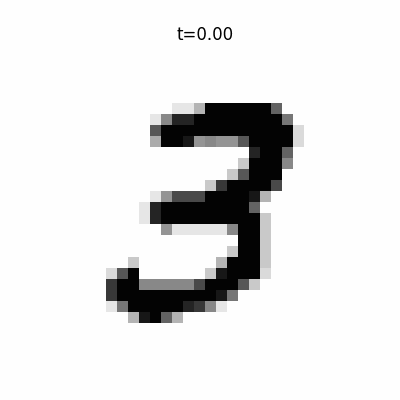

Saved animation to linear_3_to_8.gif


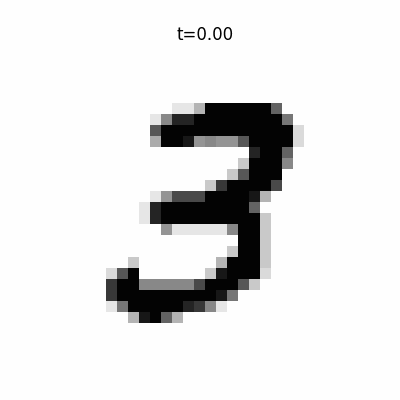

In [10]:
# Cell 8: Smooth animation of the transport
from matplotlib import animation
from IPython.display import HTML

# Infer side and prepare frames
side = int(np.round(np.sqrt(gamma.shape[0])))
n_frames = 40
ts = np.linspace(0.0, 1.0, n_frames)

fig, ax = plt.subplots(figsize=(4, 4))
# Use consistent vmin/vmax for stable contrast
vmin, vmax = 0.0, 1.0
im = ax.imshow(img1 if img1.shape == (side, side) else img1.reshape(side, side), cmap='Greys', vmin=vmin, vmax=vmax)
ax.axis('off')

def update_frame(i):
    t = ts[i]
    frame_img = make_interpolated_image(gamma, coords=coords, side=side, t=t, threshold_frac=0.0)
    im.set_data(frame_img)
    ax.set_title(f"t={t:.2f}", fontsize=12)
    return (im,)

anim = animation.FuncAnimation(fig, update_frame, frames=len(ts), interval=80, blit=True)
plt.close(fig)

# Display inline as JS animation (works in Jupyter notebooks)
HTML(anim.to_jshtml())

# Save animation as a GIF using PillowWriter (requires pillow installed)
try:
    writer = animation.PillowWriter(fps=12)
    anim.save('transport_3_to_8.gif', writer=writer)
    print('Saved animation to transport_3_to_8.gif')
except Exception as e:
    print('Could not save GIF:', e)

# Display saved GIF inline if available
from IPython.display import display, Image as IPImage
try:
    display(IPImage(filename='transport_3_to_8.gif'))
except Exception:
    pass

# ---- Linear (cross-fade) animation: simple pixel-wise interpolation ----
# Prepare source/target at the computed side
src = img1 if img1.shape == (side, side) else img1.reshape(side, side)
tgt = img2 if img2.shape == (side, side) else img2.reshape(side, side)

fig2, ax2 = plt.subplots(figsize=(4, 4))
im2 = ax2.imshow(src, cmap='Greys', vmin=0.0, vmax=1.0)
ax2.axis('off')

def update_fade(i):
    t = ts[i]
    frame = (1 - t) * src + t * tgt
    # normalize for display to match previous visual style
    if frame.max() > 0:
        frame = frame / frame.max()
    im2.set_data(frame)
    ax2.set_title(f"t={t:.2f}", fontsize=12)
    return (im2,)

anim2 = animation.FuncAnimation(fig2, update_fade, frames=len(ts), interval=80, blit=True)
plt.close(fig2)

# Save linear fade GIF
try:
    writer = animation.PillowWriter(fps=12)
    anim2.save('linear_3_to_8.gif', writer=writer)
    print('Saved animation to linear_3_to_8.gif')
except Exception as e:
    print('Could not save linear GIF:', e)

# Display saved linear GIF inline if available
try:
    display(IPImage(filename='linear_3_to_8.gif'))
except Exception:
    pass

## Embedding with Optimal Transport Distances

We can use the Earth Mover's Distance as a metric to embed the digits into a 2D space. This allows us to visualize how "close" different digits are in terms of their geometry.

Since computing OT distances is expensive, we will select a small subset of the dataset (e.g., 10 images per digit).

In [21]:
# Data Selection for t-SNE
# We'll select a subset of images to compute the pairwise OT distance matrix.

n_per_digit = 500
subset_indices = []
subset_labels = []

for digit in range(10):
    indices = np.where(y_train == digit)[0][:n_per_digit]
    subset_indices.extend(indices)
    subset_labels.extend([digit] * n_per_digit)

subset_images = x_train[subset_indices].astype(np.float64)
subset_labels = np.array(subset_labels)

# ---------------------------------------------------------
# COARSENING (Downsampling)
# ---------------------------------------------------------
# Reduce 28x28 -> 14x14 to speed up OT computation for winter school (Colab limits)
# We'll average 2x2 blocks ...
print(f"Original shape: {subset_images.shape}")
subset_images = subset_images.reshape(-1, 14, 2, 14, 2).mean(axis=(2, 4))
print(f"Coarsened shape: {subset_images.shape}")

# Normalize
subset_images = subset_images.reshape(len(subset_images), -1) # Flatten
subset_images /= subset_images.sum(axis=1, keepdims=True)

print(f"Selected {len(subset_images)} images ({n_per_digit} per digit).")
print(f"Points per image: {subset_images.shape[1]}")

Original shape: (5000, 28, 28)
Coarsened shape: (5000, 14, 14)
Selected 5000 images (500 per digit).
Points per image: 196


In [ ]:
# Compute Pairwise OT Distance Matrix (Parallelized or GPU)
import multiprocessing
from joblib import Parallel, delayed
import time
try:
    from tqdm.auto import tqdm
except ImportError:
    def tqdm(x, **kwargs): return x

# Check for GPU
try:
    import torch
    import geomloss
    USE_GPU = torch.cuda.is_available()
except ImportError:
    USE_GPU = False

if USE_GPU:
    print("GPU detected. Using GeomLoss for accelerated Sinkhorn distances.")
    
    def compute_pairwise_matrix_gpu(images, coords, batch_size=10):
        # images: (N, n_features)
        # coords: (n_features, 2)
        
        import gc
        # Clear memory before starting
        gc.collect()
        torch.cuda.empty_cache()
        
        device = torch.device("cuda")
        N = len(images)
        n_features = images.shape[1]
        
        print(f"Moving data to GPU... (Batch size: {batch_size}, Features: {n_features})")
        # Prepare data
        # Weights must be positive and sum to 1
        w = torch.tensor(images, dtype=torch.float32).to(device)
        x = torch.tensor(coords, dtype=torch.float32).to(device)
        
        # Define Loss (Sinkhorn ~ EMD)
        # p=1 corresponds to Euclidean distance cost (|x-y|)
        # blur=0.05 is small enough for good approximation
        # scaling=0.9 helps with convergence speed
        loss_fn = geomloss.SamplesLoss("sinkhorn", p=1, blur=0.05, scaling=0.9)
        
        D_mat = np.zeros((N, N))
        
        print("Starting GPU computation...")
        
        # Loop over blocks
        for i in tqdm(range(0, N, batch_size), desc="Computing Rows"):
            # print(f"Processing row batch {i}/{N}...")
            end_i = min(i + batch_size, N)
            len_i = end_i - i
            
            # Prepare batch I
            # Shape: (len_i, 1, n_features, 2)
            w_i = w[i:end_i].unsqueeze(1) # (len_i, 1, n_features)
            x_i = x.unsqueeze(0).unsqueeze(0).expand(len_i, 1, -1, -1) # (len_i, 1, n_features, 2)
            
            # OPTIMIZATION: Only loop j starting from i (Upper Triangle)
            for j in range(i, N, batch_size):
                end_j = min(j + batch_size, N)
                len_j = end_j - j
                
                # Prepare batch J
                # Shape: (1, len_j, n_features, 2)
                w_j = w[j:end_j].unsqueeze(0) # (1, len_j, n_features)
                x_j = x.unsqueeze(0).unsqueeze(0).expand(1, len_j, -1, -1) # (1, len_j, n_features, 2)
                
                # Broadcast to (len_i, len_j, n_features, 2)
                # We flatten to (len_i * len_j, n_features, 2) for geomloss
                # NOTE: We must use .contiguous() because geomloss uses .view() internally
                
                w_i_flat = w_i.expand(-1, len_j, -1).contiguous().view(-1, n_features)
                x_i_flat = x_i.expand(-1, len_j, -1, -1).contiguous().view(-1, n_features, 2)
                
                w_j_flat = w_j.expand(len_i, -1, -1).contiguous().view(-1, n_features)
                x_j_flat = x_j.expand(len_i, -1, -1, -1).contiguous().view(-1, n_features, 2)
                
                # Compute loss
                with torch.no_grad():
                    # Returns (Batch,)
                    dists = loss_fn(w_i_flat, x_i_flat, w_j_flat, x_j_flat)
                
                # Reshape and store
                block_res = dists.view(len_i, len_j).cpu().numpy()
                D_mat[i:end_i, j:end_j] = block_res
                
                # Symmetric fill (avoid recomputing lower triangle)
                if i != j:
                    D_mat[j:end_j, i:end_i] = block_res.T
                
                # Clean up intermediate tensors
                del w_i_flat, x_i_flat, w_j_flat, x_j_flat, dists, block_res
                
            # Clear cache after each row block to prevent fragmentation
            torch.cuda.empty_cache()
                
        return D_mat

    # Run GPU computation
    start_time = time.time()
    
    # Ensure coords match the image size (important if we coarsened the data)
    n_features = subset_images.shape[1]
    side = int(np.sqrt(n_features))
    
    # Regenerate coords to match the current image resolution
    x_grid, y_grid = np.mgrid[0:side, 0:side]
    coords = np.vstack((x_grid.flatten(), y_grid.flatten())).T
    
    # If we are using coarsened images (14x14), the coordinates are 0..13.
    # This is fine for relative distances.
        
    D_ot = compute_pairwise_matrix_gpu(subset_images, coords, batch_size=20)
    print(f"GPU Computation time: {time.time() - start_time:.2f}s")

else:
    print("GPU not found or libraries missing. Using CPU parallel processing.")
    n_cores = multiprocessing.cpu_count()
    print(f"Using {n_cores} cores for computation.")

    n_samples = len(subset_images)
    D_ot = np.zeros((n_samples, n_samples))

    # Define helper function for parallel execution
    def compute_ot_pair(i, j, img_i, img_j, M):
        # ot.emd2 returns the transport cost
        val = ot.emd2(img_i, img_j, M)
        return i, j, val

    print("Computing pairwise Wasserstein distances...")
    
    # Ensure M matches the image size
    n_features = subset_images.shape[1]
    side = int(np.sqrt(n_features))
    x_grid, y_grid = np.mgrid[0:side, 0:side]
    coords = np.vstack((x_grid.flatten(), y_grid.flatten())).T
    M = ot.dist(coords, coords, metric='euclidean')
    M /= M.max()

    # Create list of pairs (upper triangle)
    pairs = [(i, j) for i in range(n_samples) for j in range(i + 1, n_samples)]
    print(f"Total pairs to compute: {len(pairs)}")

    # Run in parallel with joblib verbose output
    results = Parallel(n_jobs=n_cores, verbose=5)(
        delayed(compute_ot_pair)(i, j, subset_images[i], subset_images[j], M) 
        for i, j in pairs
    )

    # Fill the matrix
    for i, j, val in results:
        D_ot[i, j] = val
        D_ot[j, i] = val

print("Distance matrix computed.")

plt.figure(figsize=(6, 6))
plt.imshow(D_ot, cmap='viridis', origin='lower')
plt.title("Pairwise OT Distance Matrix")
plt.colorbar()
plt.show()

GPU not found or libraries missing. Using CPU parallel processing.
Using 192 cores for computation.
Computing pairwise Wasserstein distances...
Total pairs to compute: 12497500


[Parallel(n_jobs=192)]: Using backend LokyBackend with 192 concurrent workers.
[Parallel(n_jobs=192)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=192)]: Done 264 tasks      | elapsed:    0.2s
[Parallel(n_jobs=192)]: Done 612 tasks      | elapsed:    0.4s
[Parallel(n_jobs=192)]: Done 1152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=192)]: Done 1764 tasks      | elapsed:    0.9s
[Parallel(n_jobs=192)]: Done 2448 tasks      | elapsed:    1.2s
[Parallel(n_jobs=192)]: Done 3204 tasks      | elapsed:    1.5s
[Parallel(n_jobs=192)]: Done 4032 tasks      | elapsed:    1.8s
[Parallel(n_jobs=192)]: Done 4932 tasks      | elapsed:    2.2s
[Parallel(n_jobs=192)]: Done 5904 tasks      | elapsed:    2.6s
[Parallel(n_jobs=192)]: Done 6948 tasks      | elapsed:    3.0s
[Parallel(n_jobs=192)]: Done 8064 tasks      | elapsed:    3.5s
[Parallel(n_jobs=192)]: Done 9252 tasks      | elapsed:    4.4s
[Parallel(n_jobs=192)]: Done 10512 tasks      | elapsed:    4.9s
[Parallel(n_jobs=192)]: Don

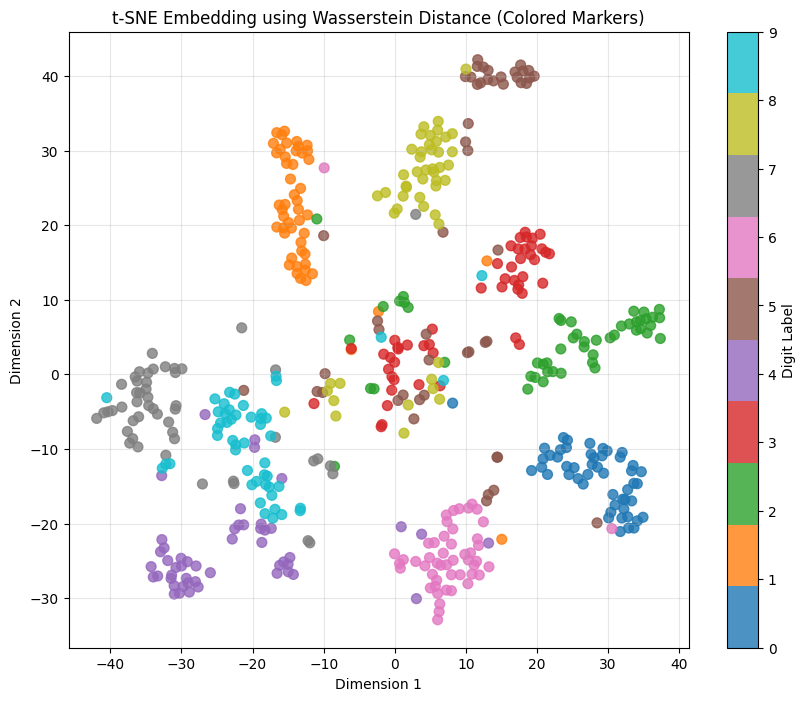

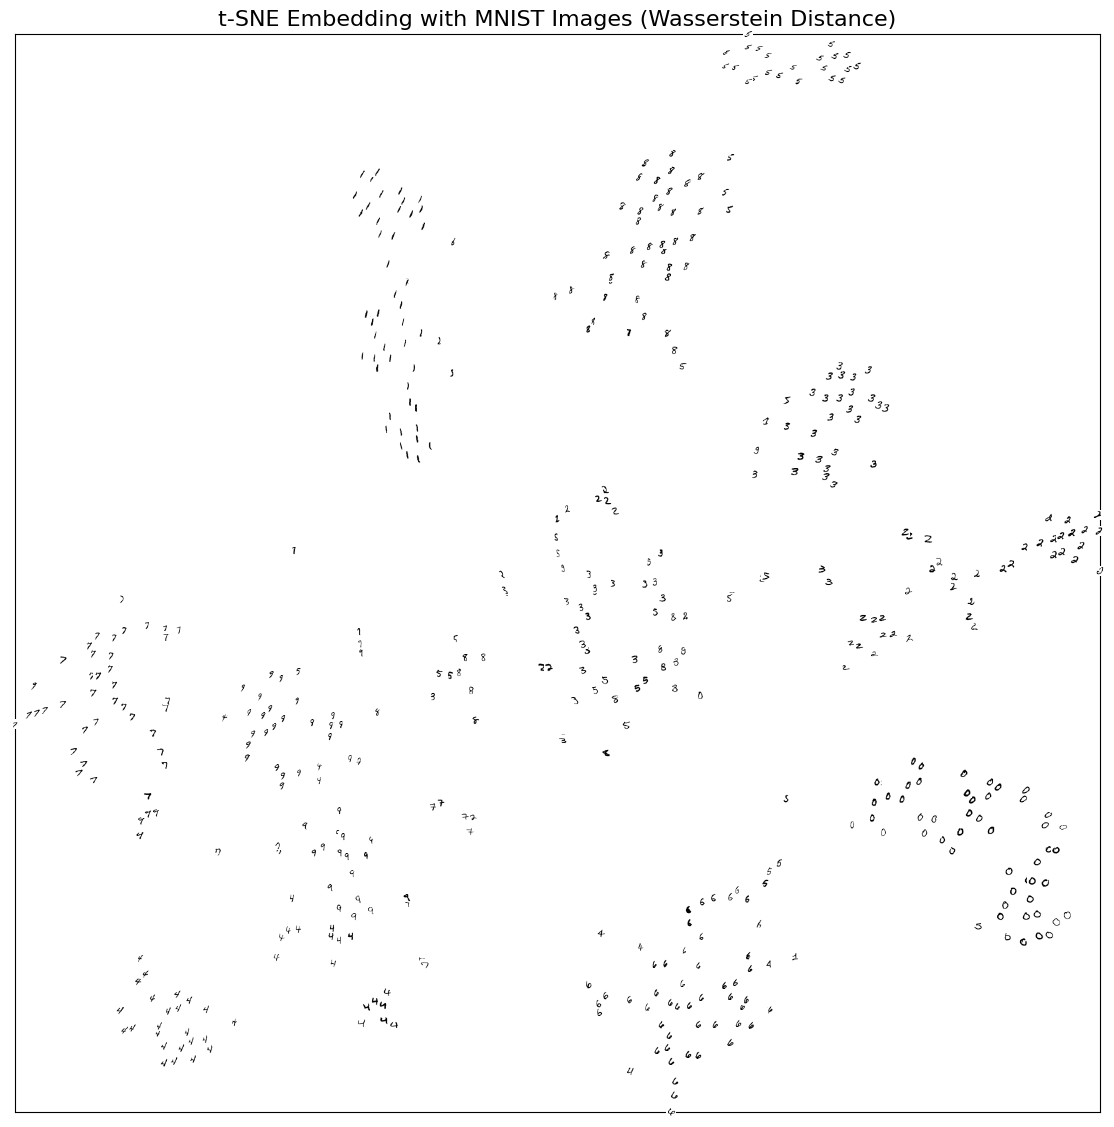

In [18]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# t-SNE Embedding with precomputed distance matrix
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42, perplexity=15)
embedding = tsne.fit_transform(D_ot)

# 1. Standard Visualization (Colored Markers)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=subset_labels, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, label='Digit Label')
plt.title("t-SNE Embedding using Wasserstein Distance (Colored Markers)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Visualization with Images
def plot_embedding_images(X, images, title=None):
    # Normalize coordinates to [0, 1] for easier scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(14, 14))
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        # Reshape and normalize for display (0-1 range)
        img = images[i].reshape(14, 14)
        img = img / img.max() 
        
        # Create image box
        # zoom=0.5 controls the size of the images on the plot
        # cmap='gray_r' inverts the colors (black digit on white background)
        imagebox = OffsetImage(img, zoom=0.5, cmap='gray_r') 
        ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]), frameon=False, pad=0.0)
        ax.add_artist(ab)
    
    plt.xticks([]), plt.yticks([])
    if title:
        plt.title(title, fontsize=16)
    plt.show()

plot_embedding_images(embedding, subset_images, "t-SNE Embedding with MNIST Images (Wasserstein Distance)")

## Prototypes and Outliers

Using the pairwise Wasserstein distances, we can identify which images are most central to their cluster (prototypes) and which are most distant (outliers).

*   **Prototype:** The image with the minimum average distance to all other images of the same digit.
*   **Outlier:** The image with the maximum average distance to all other images of the same digit.

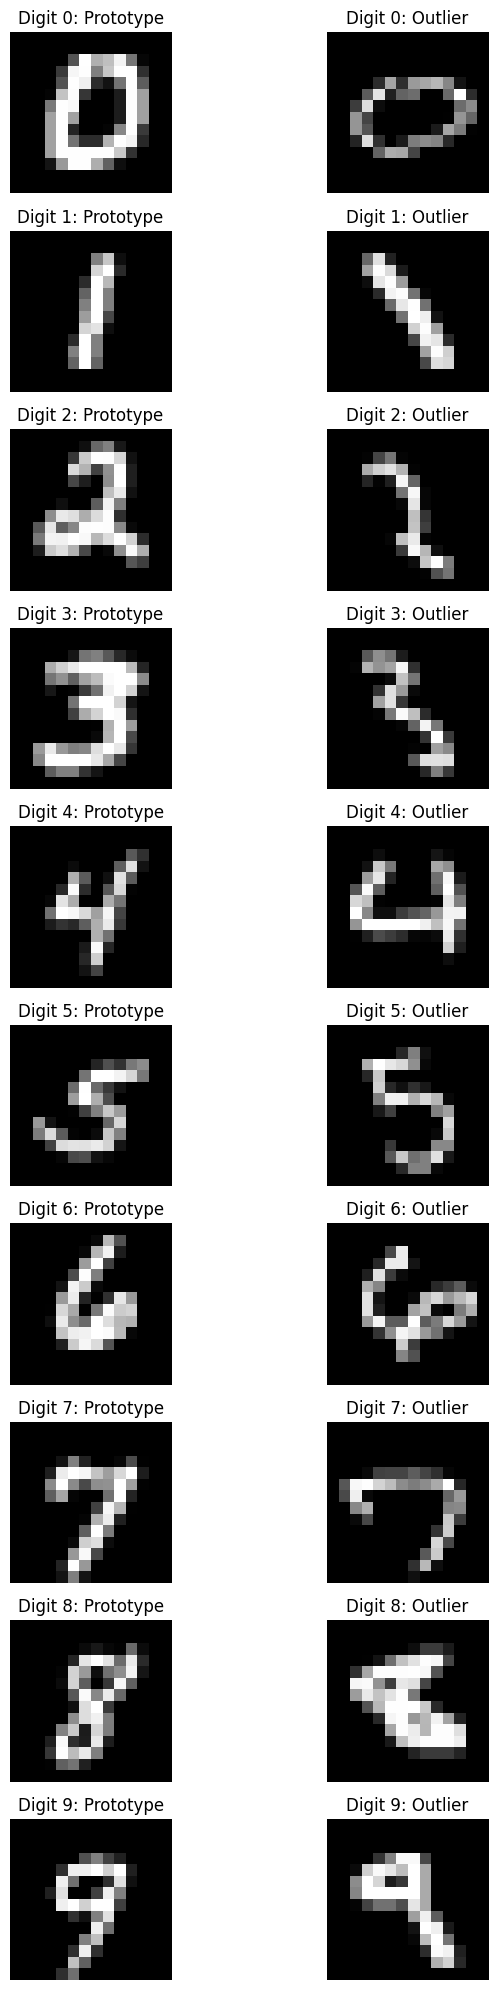

In [19]:
# Find Most and Least Representative Digits
# For each digit, we find the sample with the smallest average OT distance to others of the same class (prototype)
# and the largest average OT distance (outlier).

plt.figure(figsize=(8, 20))

for digit in range(10):
    # Get indices for this digit
    indices = np.where(subset_labels == digit)[0]
    
    # Extract sub-matrix of distances for this digit
    # D_ot is the precomputed NxN distance matrix
    sub_matrix = D_ot[np.ix_(indices, indices)]
    
    # Compute average distance of each sample to all others in the class
    avg_dist = sub_matrix.mean(axis=1)
    
    # Find min (prototype) and max (outlier)
    idx_proto = indices[np.argmin(avg_dist)]
    idx_outlier = indices[np.argmax(avg_dist)]
    
    # Plot Prototype
    plt.subplot(10, 2, 2 * digit + 1)
    img_proto = subset_images[idx_proto].reshape(14, 14)
    plt.imshow(img_proto, cmap='gray')
    plt.title(f"Digit {digit}: Prototype")
    plt.axis('off')
    
    # Plot Outlier
    plt.subplot(10, 2, 2 * digit + 2)
    img_outlier = subset_images[idx_outlier].reshape(14, 14)
    plt.imshow(img_outlier, cmap='gray')
    plt.title(f"Digit {digit}: Outlier")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Morphological Confusion Matrix

The grid below shows the "confusion candidates" between digits.
*   **Row $i$, Column $j$:** Displays the specific image of **Digit $i$** that has the smallest average Wasserstein distance to the cluster of **Digit $j$**.
*   This answers questions like: *"Which '2' looks most like a '7'?"* or *"Which '5' looks most like a '6'?"*
*   The diagonal elements $(i, i)$ correspond to the prototypes (most representative images) found above.

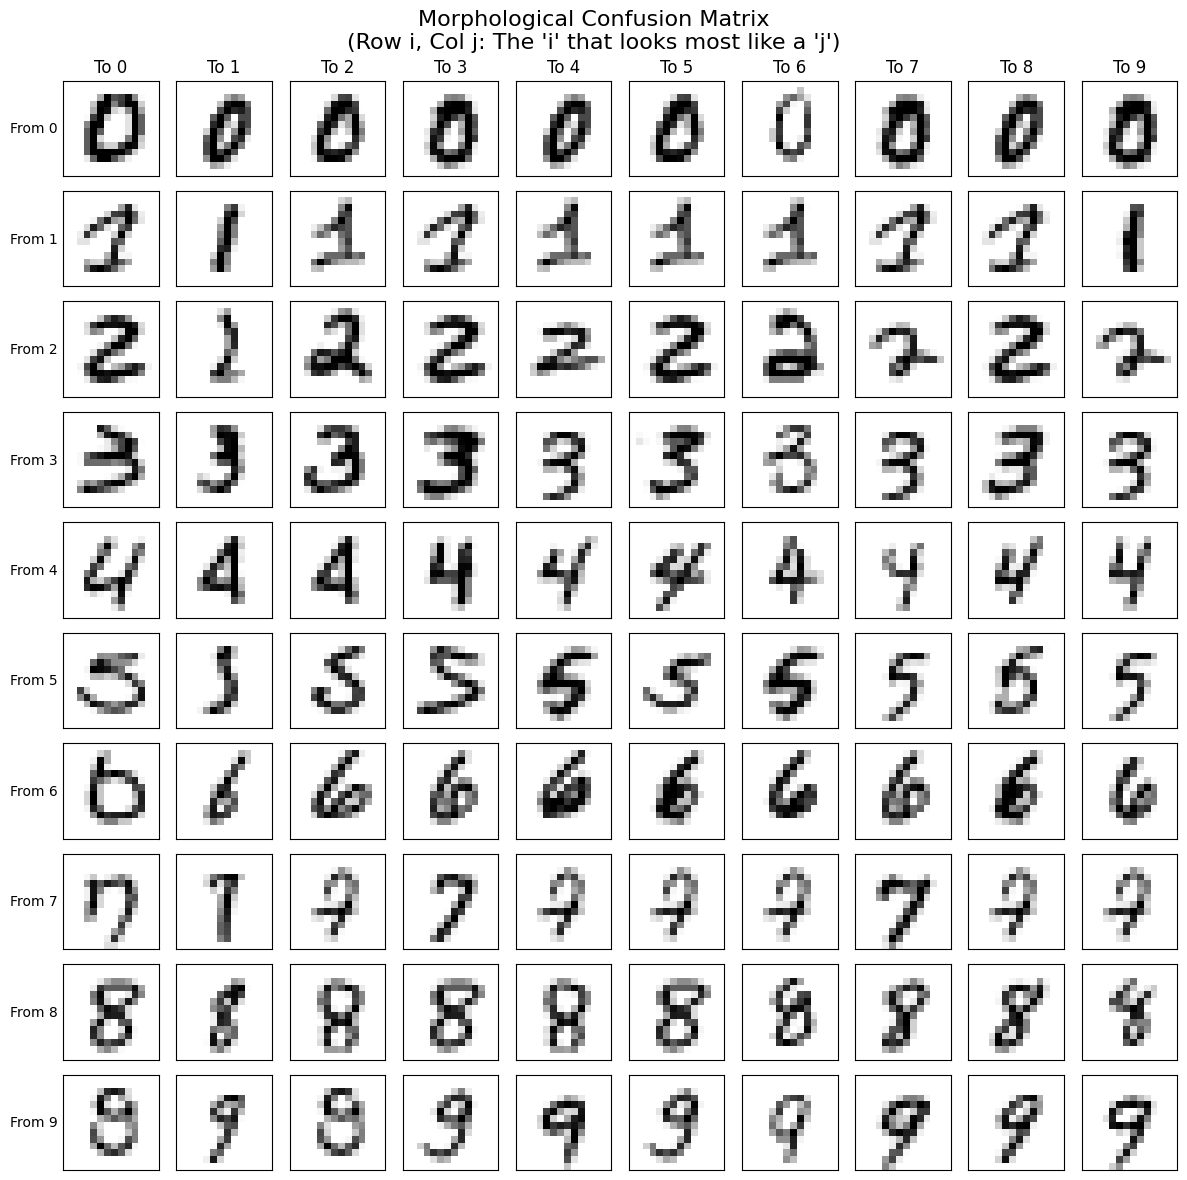

In [20]:
# Visualize the "Confusion Matrix" of Morphologies
n_classes = 10
plt.figure(figsize=(12, 12))

for i in range(n_classes):
    indices_i = np.where(subset_labels == i)[0]
    for j in range(n_classes):
        indices_j = np.where(subset_labels == j)[0]
        
        # Extract sub-matrix of distances between class i (rows) and class j (cols)
        # D_ot is the precomputed NxN distance matrix
        dists = D_ot[np.ix_(indices_i, indices_j)]
        
        # Find sample in i that is closest to class j on average
        # We average over the columns (target class j) to find how close each 'i' is to the 'j' cluster
        avg_dists = dists.mean(axis=1)
        best_idx_local = np.argmin(avg_dists)
        best_idx_global = indices_i[best_idx_local]
        
        # Plot
        plt.subplot(n_classes, n_classes, i * n_classes + j + 1)
        img = subset_images[best_idx_global].reshape(14, 14)
        plt.imshow(img, cmap='gray_r') # Inverted gray for better visibility of thin strokes
        
        # Labels
        if i == 0:
            plt.title(f"To {j}")
        if j == 0:
            plt.ylabel(f"From {i}", rotation=0, ha='right', va='center')
            
        plt.xticks([])
        plt.yticks([])

plt.suptitle("Morphological Confusion Matrix\n(Row i, Col j: The 'i' that looks most like a 'j')", fontsize=16)
plt.tight_layout()
plt.show()